In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from time import perf_counter as time
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import scipy.ndimage

In [2]:
# Import resampled image
fileName = '../resampling/X19_resampled_uint8.nii'
niiVol = nib.load(fileName)

affine = niiVol.affine
imgDim = niiVol.header['dim'][1:4]
imgSpacing = niiVol.header['pixdim'][1:4]

print('Image dimensions and voxel size')
print(imgDim)
print(imgSpacing)

print('\nThe affine matrix of the original volume')
print(affine)

Image dimensions and voxel size
[1576 1923 1029]
[0.0434798 0.0434798 0.0434798]

The affine matrix of the original volume
[[0.0434798 0.        0.        0.0434798]
 [0.        0.0434798 0.        0.0434798]
 [0.        0.        0.0434798 0.0434798]
 [0.        0.        0.        1.       ]]


In [4]:
# Downsample volume to make the processing faster for this demo

factor = 4
#newSz = np.floor(np.array(imgDim) / factor).astype(int)

# Remember to also scale the pixel-dimension
affine = np.copy(affine)
affine[0,0] = affine[0,0]*factor
affine[1,1] = affine[1,1]*factor
affine[2,2] = affine[2,2]*factor
imgSpacing = imgSpacing * factor

# Downsample
vol = scipy.ndimage.zoom(niiVol.get_fdata().astype('float32'), 1/factor, order=2)
imgDim = vol.shape

print('Image dimensions and voxel size')
print(imgDim)
print(imgSpacing)

print('\nThe affine matrix of the original volume')
print(affine)

Image dimensions and voxel size
[ 98 120  64]
[0.6956768 0.6956768 0.6956768]

The affine matrix of the original volume
[[0.6956768 0.        0.        0.0434798]
 [0.        0.6956768 0.        0.0434798]
 [0.        0.        0.6956768 0.0434798]
 [0.        0.        0.        1.       ]]


In [11]:
# Set up grid interpolator for the resampled image

# --- Choose inter-/extra-polation --- #

intMethod = 'linear' #Options: "linear", "nearest", "slinear", "cubic", "quintic" and "pchip" 
expVal = 0.0 #Value for extrapolation (i.e. values outside volume domain)

# ------------------------------------ #

# Set-up interpolator for the image/volume
x = np.arange(start=0, stop=imgDim[0], step=1) * imgSpacing[0] + affine[0,3]
y = np.arange(start=0, stop=imgDim[1], step=1) * imgSpacing[1] + affine[1,3]
z = np.arange(start=0, stop=imgDim[2], step=1) * imgSpacing[2] + affine[2,3]
F_vol = RegularGridInterpolator((x, y, z), vol, method=intMethod, bounds_error=False, fill_value=expVal)

#  Can also be specified in voxel-coordinates
#x = np.arange(start=0, stop=imgDim[0], step=1) 
#y = np.arange(start=0, stop=imgDim[1], step=1) 
#z = np.arange(start=0, stop=imgDim[2], step=1)


In [12]:
# Threshold and marching cubes
threshold = 130

vertices_f, faces_f, normals_f, labels_f = measure.marching_cubes(vol > threshold , 0.5)
mesh_f = Poly3DCollection(vertices_f[faces_f], alpha=1.0, facecolors='r', edgecolors='r', shade=True)


In [13]:
# Helper function to marching cube meshes
def plotMesh(ax, mesh, ax_x, ax_y, ax_z, azim, elev):
    
    ax.add_collection3d(mesh)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(ax_x[0], ax_x[1])  
    ax.set_ylim(ax_y[0], ax_y[1])  
    ax.set_zlim(ax_z[0], ax_z[1]) 
    ax.set_aspect('equal')
    ax.azim = azim
    ax.elev = elev

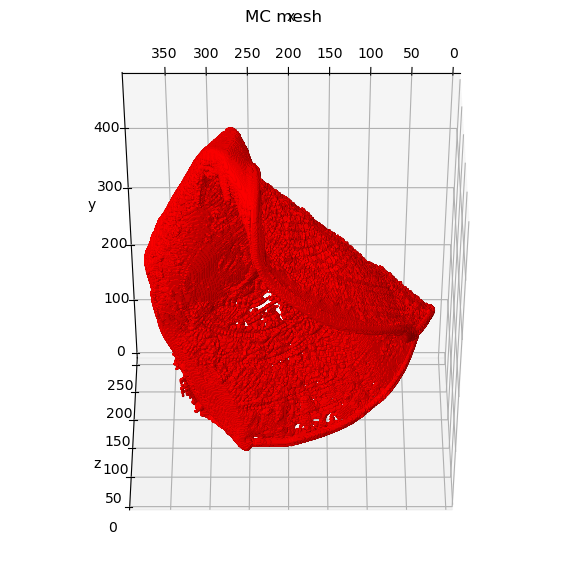

In [14]:
# Display the marching cubes meshes side-by-side

# ShowCase
ls = LightSource(azdeg=225.0, altdeg=45.0)
fig = plt.figure(figsize=(24, 8))

# Set up scene for fixed
ax = fig.add_subplot(1,3,1, projection='3d')
plotMesh(ax, mesh_f, [0, imgDim[0]], [0, imgDim[1]], [0, imgDim[2]], azim=90, elev=-45)
ax.set_title('MC mesh')

# Display
plt.show()

In [19]:
# Convert vertices to physical coordinates
vertices_ft = vertices_f @ affine[0:3,0:3] + np.transpose(affine[0:3,3])

print('Voxel coordinates:')
print(vertices_f[0:100:10,:])

print('\nWorld coordinates:')
print(vertices_ft[0:100:10,:])

Voxel coordinates:
[[ 12.5 137.  208. ]
 [ 13.  139.  203.5]
 [ 14.  133.5 212. ]
 [ 13.5 135.  210. ]
 [ 13.5 136.  208. ]
 [ 13.5 137.  205. ]
 [ 14.  137.5 203. ]
 [ 13.5 139.  200. ]
 [ 13.5 139.  208. ]
 [ 13.5 140.  203. ]]

World coordinates:
[[  8.73943985  95.35120189 144.74425495]
 [  9.08727825  96.7425555  141.61370933]
 [  9.78295505  92.91633308 147.52696216]
 [  9.43511665  93.95984828 146.13560855]
 [  9.43511665  94.65552509 144.74425495]
 [  9.43511665  95.35120189 142.65722454]
 [  9.78295505  95.69904029 141.26587093]
 [  9.43511665  96.7425555  139.17884052]
 [  9.43511665  96.7425555  144.74425495]
 [  9.43511665  97.4382323  141.26587093]]


In [22]:
# Sample volume intensities
fVal = F_vol(vertices_ft) # Evaluate points in the image interpolator

print('Volumen intensities sampled:')
print(fVal[0:100:10])

Volumen intensities sampled:
[ 84.39029884 111.23337555 123.4897995  121.76823616 125.6528244
 102.00684643 127.90820694  82.02493824 128.03692436 163.02069473]


In [54]:
# Convert to RGB color
rgbColor = np.transpose(np.tile(fVal.astype('uint8'),(3,1))) / 255
print('RGB color:')
print(rgbColor[0:100:10,:])

RGB color:
[[0.32941176 0.32941176 0.32941176]
 [0.43529412 0.43529412 0.43529412]
 [0.48235294 0.48235294 0.48235294]
 [0.4745098  0.4745098  0.4745098 ]
 [0.49019608 0.49019608 0.49019608]
 [0.4        0.4        0.4       ]
 [0.49803922 0.49803922 0.49803922]
 [0.32156863 0.32156863 0.32156863]
 [0.50196078 0.50196078 0.50196078]
 [0.63921569 0.63921569 0.63921569]]


<IPython.core.display.Javascript object>


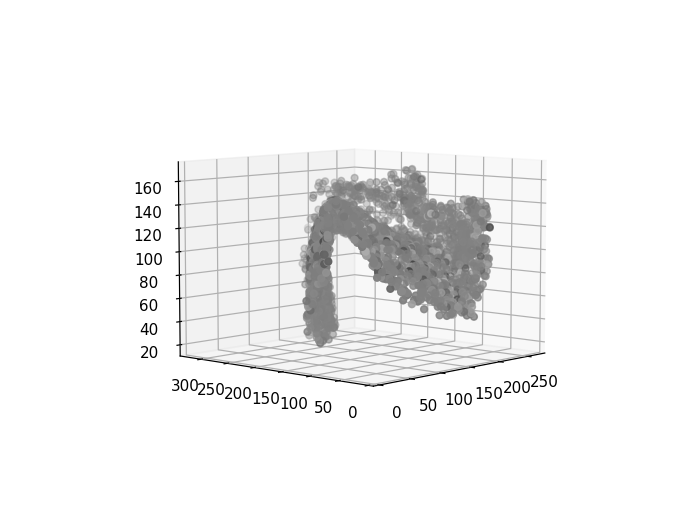

In [53]:
# Color the mesh - though I don't think matplotlibs Poly3DCollection support vertex coloring?

# So here I just plot a subset of vertices as points with rgbColor
%matplotlib notebook

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(vertices_ft[1::500,0],vertices_ft[1::500,1],vertices_ft[1::500,2], color=rgbColor[1::500,:])
